In [1]:
import dataloader
import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sample_x, sample_y = dataloader.generate_data_tf(isTrain=True, batch_size=128)
print("Dimensions of the dataset for 3 X and 3 Y training examples : ")
print(sample_x.shape)
print(sample_y.shape)
print("(seq_length, batch_size, output_dim)")

#internal neural network parameters
input_seq_length = sample_x.shape[0]
output_seq_length = sample_y.shape[0]
#seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 512  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

input_dim = sample_x.shape[-1]
output_dim = sample_y.shape[-1]
print('inp_dim', input_dim)
print('out_dim', output_dim)
#output_dim = input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 128  # Count of hidden neurons in the recurrent units. 
num_stacked_layers = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 300  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting

CKPT_PATH = 'nn_models/tf/'
MODEL_NAME = str(nb_iters) + '_iter_new.ckpt'

c:\users\deyan\tf-workspace\env\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Dimensions of the dataset for 3 X and 3 Y training examples : 
(288, 128, 17)
(48, 128, 1)
(seq_length, batch_size, output_dim)
inp_dim 17
out_dim 1


In [ ]:
# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")

In [ ]:
from s2s import * 

sample_x, sample_y = dataloader.generate_data_tf(isTrain=True, batch_size=128)

train_losses = []
test_losses = []

def train_batch_v2(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=True, batch_size=batch_size)
    feed_dict = {rnn_model['enc_inp'][t]: X[t] for t in range(input_seq_length)}
    feed_dict.update({rnn_model['target_seq'][t]: Y[t] for t in range(output_seq_length)})
    feed_dict[rnn_model['keep_prob']] = 0.7
    _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
    return loss_t

def test_batch_v2(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=batch_size)
    feed_dict = {rnn_model['enc_inp'][t]: X[t] for t in range(input_seq_length)}
    feed_dict.update({rnn_model['target_seq'][t]: Y[t] for t in range(output_seq_length)})
    feed_dict[rnn_model['keep_prob']] = 1.0
    loss_t = sess.run([rnn_model['loss']], feed_dict)
    return loss_t[0]

rnn_model = build_graph(feed_previous = True, 
  input_seq_length=input_seq_length, 
  output_seq_length=output_seq_length, 
  hidden_dim=hidden_dim, 
  input_dim=input_dim, 
  output_dim=output_dim, 
  num_stacked_layers=num_stacked_layers, 
  GRADIENT_CLIPPING=2.5, 
  learning_rate = 0.001, 
  lambda_l2_reg = 0.003)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(nb_iters + 1):
        train_loss = train_batch_v2(batch_size)
        train_losses.append(train_loss)

        if i % 50 == 0: 
            # Tester
            test_loss = test_batch_v2(batch_size)
            test_losses.append(test_loss)
            print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(i, nb_iters, train_loss, test_loss))
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, CKPT_PATH + MODEL_NAME)

    print("Checkpoint saved at: ", save_path)

Instructions for updating:
Use the retry module or similar alternatives.


In [9]:
len(rnn_model['enc_inp'])

15

In [3]:

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(input_seq_length)
    ]

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(output_seq_length)
    ]
    
    # Give a "GO" token to the decoder. 
    # Note: we might want to fill the encoder with zeros or its own feedback rather than with "+ enc_inp[:-1]"
    dec_inp = [ tf.zeros_like(expected_sparse_output[0], dtype=np.float32, name="GO") ] + expected_sparse_output[:-1]

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    keep_prob = tf.placeholder(tf.float32)
            
    #cell = [tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob = self.keep_prob) for i in range(num_layers)]
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(
                tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(hidden_dim), output_keep_prob = keep_prob
                ))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    # Here, the encoder and the decoder uses the same cell, HOWEVER,
    # the weights aren't shared among the encoder and decoder, we have two
    # sets of weights created under the hood according to that function's def. 
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    
    
    
    # For reshaping the output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # Final outputs: with linear rescaling for enabling possibly large and unrestricted output values.
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]


In [4]:

# Training loss and optimizer

with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    #optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)


In [6]:

def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=True, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    feed_dict[keep_prob] = 0.7
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    feed_dict[keep_prob] = 1.0
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 50 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/700, train loss: 583.8331298828125, 	TEST loss: 770.6626586914062
Step 50/700, train loss: 7.135094165802002, 	TEST loss: 2.869372844696045
Step 100/700, train loss: 5.249966144561768, 	TEST loss: 1.4750995635986328
Step 150/700, train loss: 3.763611078262329, 	TEST loss: 1.3329620361328125
Step 200/700, train loss: 4.249992847442627, 	TEST loss: 1.2097017765045166
Step 250/700, train loss: 3.75070858001709, 	TEST loss: 1.1033387184143066
Step 300/700, train loss: 3.611480474472046, 	TEST loss: 1.0321284532546997
Step 350/700, train loss: 3.041060209274292, 	TEST loss: 1.066084623336792
Step 400/700, train loss: 3.1935315132141113, 	TEST loss: 0.9801443219184875
Step 450/700, train loss: 2.779472827911377, 	TEST loss: 0.8642918467521667
Step 500/700, train loss: 2.937063694000244, 	TEST loss: 0.9133692979812622
Step 550/700, train loss: 3.2844982147216797, 	TEST loss: 0.89068204164505
Step 600/700, train loss: 2.676767587661743, 	TEST loss: 0.896045446395874
Step 650/700, train 

In [7]:
saver = tf.train.Saver()
save_path = saver.save(sess, "nn_models/tf/700_iter.ckpt")

In [23]:
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

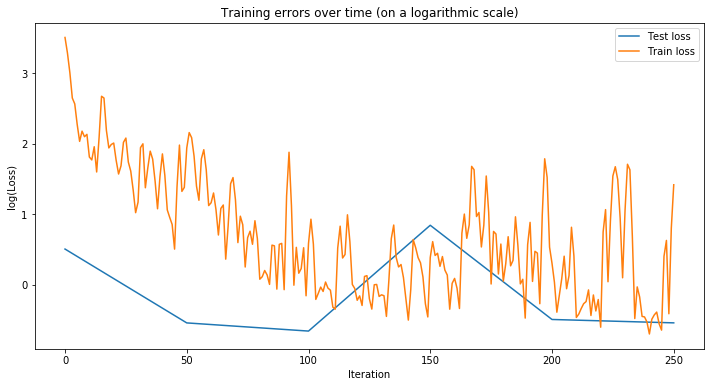

In [7]:

# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


# Inference

In [9]:
# s2s.py model
rnn_model = build_graph(feed_previous = True, 
  input_seq_length=input_seq_length, 
  output_seq_length=output_seq_length, 
  hidden_dim=hidden_dim, 
  input_dim=input_dim, 
  output_dim=output_dim, 
  num_stacked_layers=num_stacked_layers, 
  GRADIENT_CLIPPING=2.5, 
  learning_rate = 0.001, 
  lambda_l2_reg = 0.003)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = rnn_model['saver']().restore(sess, CKPT_PATH + MODEL_NAME)

INFO:tensorflow:Restoring parameters from nn_models/tf/250_iter_new.ckpt


In [12]:
t = np.array([0,2,4])
y = np.array([0,2,2])
np.mean((t-y)**2)

1.3333333333333333

(288, 5, 17) (48, 5, 1)
outputs_shape (48, 5, 1)
Test mse is:  0.014555854721100256
(288,) (48,) (48,)
Test mse is:  1394620.7506593394


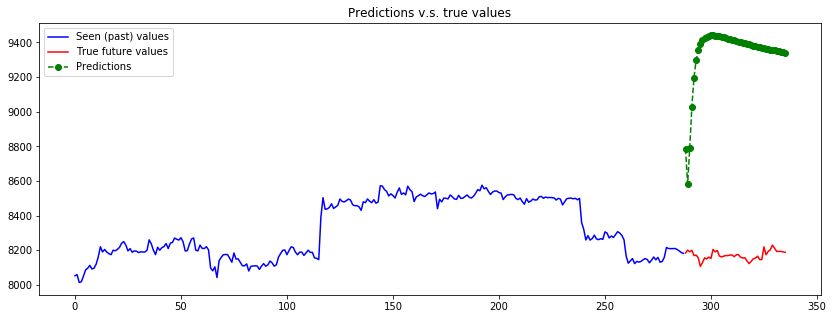

Test mse is:  0.010442166265060658
(288,) (48,) (48,)
Test mse is:  1000481.4796784092


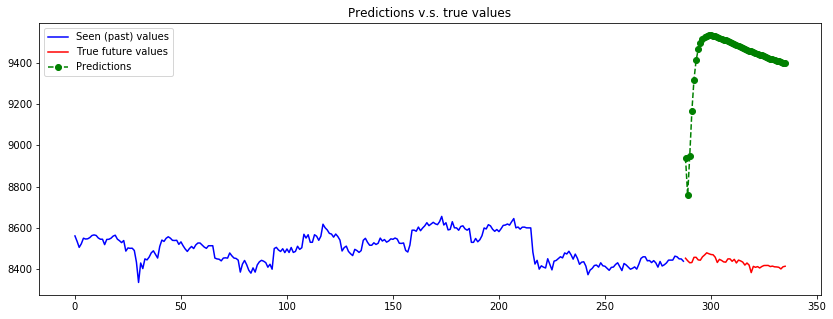

Test mse is:  0.011166766791747842
(288,) (48,) (48,)
Test mse is:  1069906.4659162338


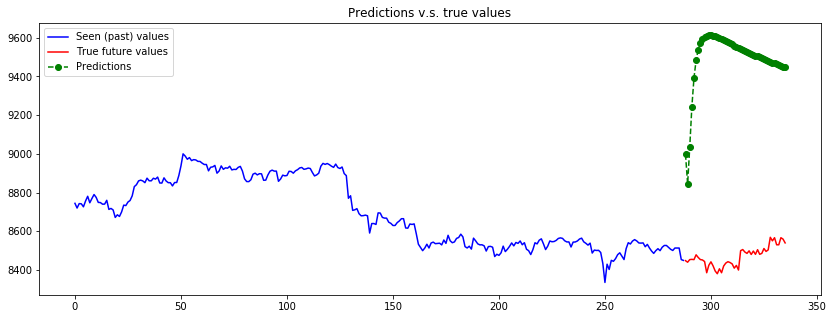

Test mse is:  0.0025631336281469607
(288,) (48,) (48,)
Test mse is:  245578.0257069356


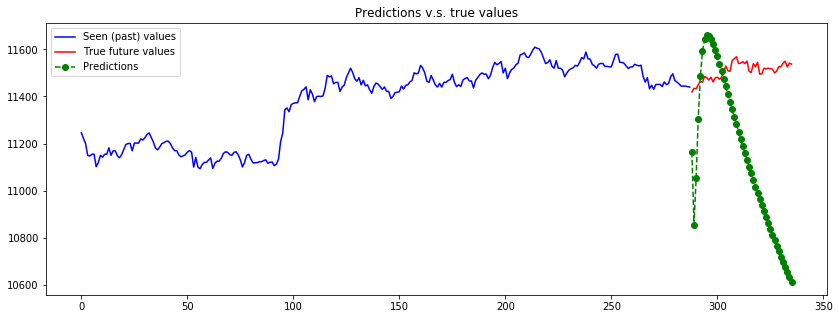

Test mse is:  0.01173558853626287
(288,) (48,) (48,)
Test mse is:  1124406.3442988002


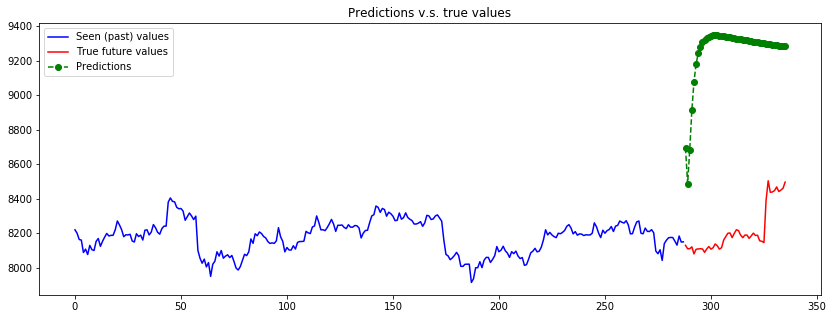

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [12]:
nb_predictions = 5

X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=nb_predictions)
print(X.shape, Y.shape)
feed_dict = {rnn_model['enc_inp'][t]: X[t] for t in range(input_seq_length)}
feed_dict.update({rnn_model['target_seq'][t]: np.ones([nb_predictions, output_dim]) for t in range(output_seq_length)})
feed_dict[rnn_model['keep_prob']] = 1
outputs = np.array(sess.run([rnn_model['reshaped_outputs']], feed_dict)[0])
print('outputs_shape', outputs.shape)



for j in range(nb_predictions): 
    plt.figure(figsize=(14, 5))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        print("Test mse is: ", np.mean((pred - expected)**2))
        #print(pred)
        
        print(past.shape, expected.shape, pred.shape)
        
        dataloader.denormalize_1d(past, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(expected, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        dataloader.denormalize_1d(pred, dataloader.scaler.min_[k], dataloader.scaler.scale_[k])
        
        print("Test mse is: ", np.mean((pred - expected)**2))
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "r", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--g", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")

In [22]:
# Test
nb_predictions = 2
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = dataloader.generate_data_tf(isTrain=False, batch_size=nb_predictions)
print(X.shape, Y.shape)
feed_dict = {enc_inp[t]: X[t] for t in range(input_seq_length)}
#{expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))}
#feed_dict.update({expected_sparse_output[t]: np.ones([nb_predictions, output_dim], dtype=np.float32)/2 for t in range(output_seq_length)})
feed_dict[keep_prob] = 0.8
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
print('outputs_shape', outputs.shape)


for j in range(nb_predictions): 
    plt.figure(figsize=(14, 5))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        print(pred)
        
        print(past.shape, expected.shape, pred.shape)
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "r", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")

Let's visualize 2 predictions with our signals:
(288, 2, 17) (48, 2, 1)


InvalidArgumentError: You must feed a value for placeholder tensor 'Seq2seq/expected_sparse_output_' with dtype float and shape [?,1]
	 [[Node: Seq2seq/expected_sparse_output_ = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Seq2seq/mul_10/_4115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_15296_Seq2seq/mul_10", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Seq2seq/expected_sparse_output_', defined at:
  File "c:\users\deyan\appdata\local\programs\python\python36\Lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\deyan\appdata\local\programs\python\python36\Lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-3dd668b0cea0>", line 17, in <module>
    for t in range(output_seq_length)
  File "<ipython-input-3-3dd668b0cea0>", line 17, in <listcomp>
    for t in range(output_seq_length)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1777, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 5496, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tensorflow\python\framework\ops.py", line 3290, in create_op
    op_def=op_def)
  File "c:\users\deyan\tf-workspace\env\lib\site-packages\tensorflow\python\framework\ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Seq2seq/expected_sparse_output_' with dtype float and shape [?,1]
	 [[Node: Seq2seq/expected_sparse_output_ = Placeholder[dtype=DT_FLOAT, shape=[?,1], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Seq2seq/mul_10/_4115 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_15296_Seq2seq/mul_10", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
